In [1]:
from nerf import utils
from jax import device_put
import jax.numpy as jnp
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from visualhull_blender import *


FLAGS = flags.FLAGS
utils.define_flags()
flags.DEFINE_integer("vsize", 400, "voxel size")
flags.DEFINE_string("voxel_dir", "data/voxel", "voxel data directory.")
flags.DEFINE_string("vh_save", "shape", "Save type ('shape' of 'color')")
flags.DEFINE_bool("vh_test", False, "If True, test the result of visual hull")
flags.DEFINE_integer("dilation", 1, "dilation size")
flags.DEFINE_integer("thresh", 100, "threshold")
config.parse_flags_with_absl()

FLAGS.alpha_bkgd = True
FLAGS.num_rgb_channels = 4
# FLAGS.alpha_bkgd = False
# FLAGS.num_rgb_channels = 3

# FLAGS.config = "configs/blender"
# FLAGS.data_dir = "data/nerf_synthetic/chair"
FLAGS.config = "configs/nsvf"
FLAGS.data_dir = "data/Synthetic_NSVF/Robot"
FLAGS.vh_test = True
utils.update_flags(FLAGS, no_nf=True)


class PureDataset(datasets.dataset_dict[FLAGS.dataset]):
    def start(self):
        pass

In [2]:
target = FLAGS.data_dir.split("/")[-1]

dataset = PureDataset("train", FLAGS)
dataset.images = dataset.images.reshape(-1,800,800,FLAGS.num_rgb_channels)
dataset.rays = dataset.rays._replace(
  origins=dataset.rays.origins.reshape(-1,800,800,3))
dataset.rays = dataset.rays._replace(
  directions=dataset.rays.directions.reshape(-1,800,800,3))
dataset.rays = dataset.rays._replace(
  viewdirs=dataset.rays.viewdirs.reshape(-1,800,800,3))

test_dataset = PureDataset("test", FLAGS)
test_dataset.images = test_dataset.images.reshape(-1,800,800,FLAGS.num_rgb_channels)
test_dataset.rays = test_dataset.rays._replace(
  origins=test_dataset.rays.origins.reshape(-1,800,800,3))
test_dataset.rays = test_dataset.rays._replace(
  directions=test_dataset.rays.directions.reshape(-1,800,800,3))
test_dataset.rays = test_dataset.rays._replace(
  viewdirs=test_dataset.rays.viewdirs.reshape(-1,800,800,3))

# test_dataset = dataset

In [6]:
utils.update_flags(FLAGS, no_nf=False)  # for NSVF
visualhull(FLAGS, dataset, test_dataset, target, dilation=11, thresh=100)

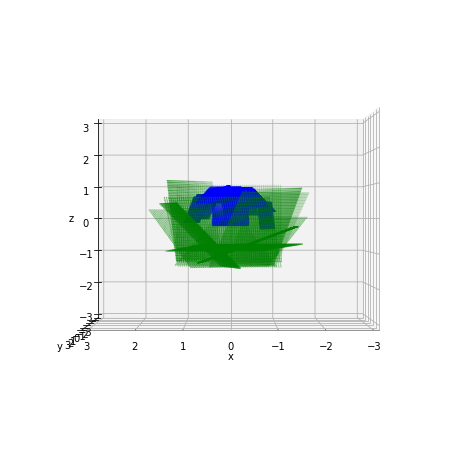

In [4]:
t_n, t_f = FLAGS.near, FLAGS.far
# t_n, t_f = 0.875, 0.875*3

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
lim=3
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
# ax.view_init(elev=90, azim=90)
ax.view_init(elev=0, azim=90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for idx in range(0, len(dataset.rays.origins), 10):
    o = dataset.rays.origins[idx]
    d = dataset.rays.directions[idx]

    # render lower limit（blue）
    x_n, y_n, z_n = (o + d * t_n)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_n, y_n, z_n, c='blue', s=0.1)

    # render upper limit (green)
    x_f, y_f, z_f = (o + d * t_f)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_f, y_f, z_f, c='green', s=0.1)

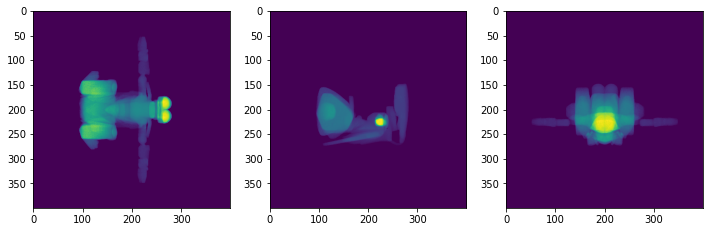

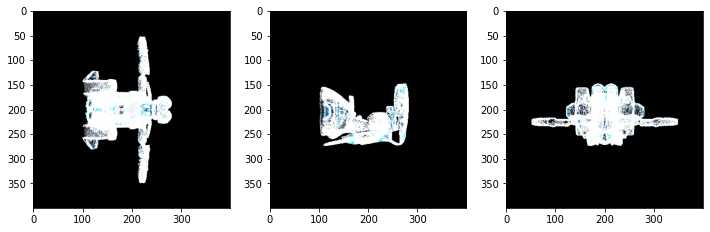

In [5]:
voxel = np.load("data/voxel_dil11/Robot/voxel.npy")
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.sum(voxel, axis=0))
plt.subplot(1,3,2); plt.imshow(np.sum(voxel, axis=1))
plt.subplot(1,3,3); plt.imshow(np.sum(voxel, axis=2))
plt.show()

voxel = np.load("data/voxel_dil11/Robot/voxel_color.npy")
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.sum(voxel, axis=0))
plt.subplot(1,3,2); plt.imshow(np.sum(voxel, axis=1))
plt.subplot(1,3,3); plt.imshow(np.sum(voxel, axis=2))
plt.show()